# Clustering Density

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
np.random.seed(123)

# Load Data

In [2]:
data = pd.read_csv(r'./maps/FVG/FVG_companies.csv', dtype='str')
data.columns = ['ind', 'cf', 'company','unit', 'lat', 'lon']
data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data.shape

(7955, 6)

# Data Exploration

In [3]:
def plot_clusters(X, cluster_labels, title=""):
    for i in np.unique(cluster_labels):
        cluster_points = X[cluster_labels == i , :]       
        if i == 0: 
            ax.scatter(cluster_points[:,0] , cluster_points[:,1] , color="yellow", marker='.', s=2)
        else:
            ax.scatter(cluster_points[:,0] , cluster_points[:,1] , cmap = i, marker='o', s=2)
    ax.set_title(title, fontweight='bold')
    return

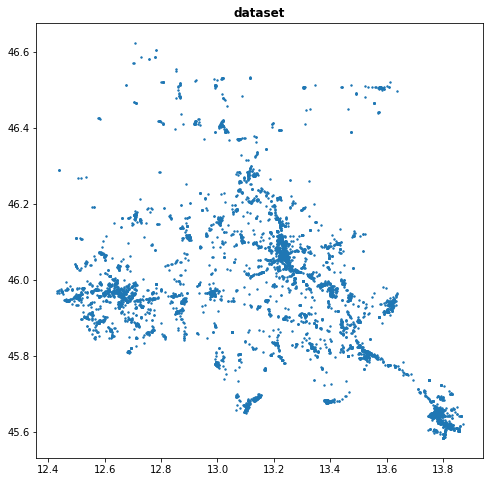

In [4]:
X = np.array(data[ ['lon','lat'  ] ]) 
n, p  = X.shape
_, ax = plt.subplots(figsize=(8,8))
plot_clusters(X, np.ones(n), title = "dataset")
plt.show()


## Scaling factor

In [5]:
# approximated, valid only at short distances but good enough to give a rougn idea of epsilon
R = 6371 #earth radius
lon1, lat1,  =  12.6, 46.0
lon2, lat2   =  13.8, 46.0
# longitude x
dx = R*(lon2-lon1)*np.cos(lat1)*np.pi/180
# latitude y
dy = R* (lat2-lat1)*np.pi/180
d =  np.sqrt(dx**2 +  dy**2)
dx, dy

(-57.66719385463093, 0.0)

In [6]:
lon1, lat1,  =  13.2, 45.6
lon2, lat2   =  13.2, 46.6
# longitude x
dx = R*(lon2-lon1)*np.cos(lat1)*np.pi/180
# latitude y
dy = R* (lat2-lat1)*np.pi/180
d =  np.sqrt(dx**2 +  dy**2)
dx, dy

(-0.0, 111.19492664455873)

In [7]:
# TODO add scaling factor 57,111 to have more "readable" values of epsilon in km

## calculate density for each point
X = data points = company position
G = grid points equally spaced

In [8]:
grid = pd.read_csv(r'./maps/FVG/FVG_grid.csv')
nbins=np.sqrt(grid.shape[0]).astype(int)
xi = np.array(grid.x).reshape(nbins,nbins)
yi = np.array(grid.y).reshape(nbins,nbins)
G =  np.array(grid)

# calculate distance matrix

In [9]:
dm = distance_matrix(G,X)
n_data_points= X.shape[0]
n_grid_points=G.shape[0]
n_reshape = np.sqrt(n_grid_points).astype(int)


In [10]:
def epsilon_neighborhood(dm, X, g, epsilon):
    """
    dm: distance_matrix(G,X)
    g: point of the grid G
    returns eps_neighb a list of indices of X that are within a distance epsilon of point G
    """
    distances = dm[g]
    eps_neighb = np.where(X[ (distances < epsilon) ])[0]
    number_of_neighb = len(eps_neighb)
    
    return number_of_neighb, eps_neighb


Given Epsilon = 0.005 and minPoints = 20, the fraction of core points is 0.0078
Given Epsilon = 0.01 and minPoints = 20, the fraction of core points is 0.033
Given Epsilon = 0.02 and minPoints = 20, the fraction of core points is 0.1128
Given Epsilon = 0.05 and minPoints = 20, the fraction of core points is 0.3616
Given Epsilon = 0.08 and minPoints = 20, the fraction of core points is 0.5074


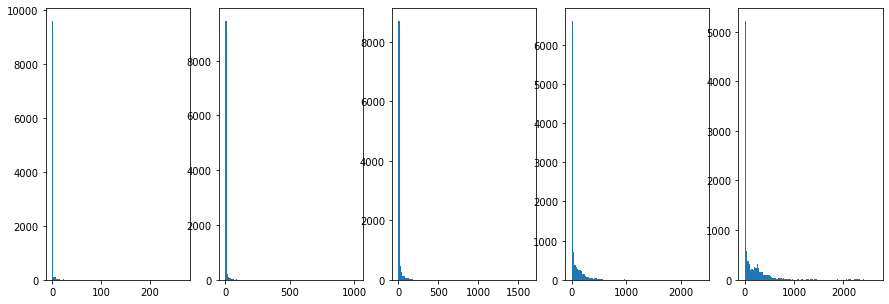

In [11]:
minPoints = 20
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (15,5))
nplot=0
for epsilon in [5e-3, 1e-2, 2e-2, 5e-2, 8e-2]:
    nn_epsilon = []
    is_core = []
    for g in range(n_grid_points):
        number_of_neighb, eps_neighb = epsilon_neighborhood(dm, X, g, epsilon)
        nn_epsilon.append(number_of_neighb)
        is_core.append( number_of_neighb > minPoints  )
    
    ax[nplot].hist(nn_epsilon, bins = 100)
    nplot+=1
    fraction_core_points = np.array(is_core).mean()
    print(f'Given Epsilon = {epsilon} and minPoints = {minPoints}, the fraction of core points is {fraction_core_points}')

select epsilon = .05, minPoints=20

# compute density

In [12]:
def compute_density(dm, X, G, epsilon):
    n_grid_points=  G.shape[0]
    n_data_points = X.shape[0]
    density = np.zeros(n_grid_points).astype(int)
    number_of_neighb = np.zeros(n_grid_points).astype(int)

    for g in range(n_grid_points):
        nnb, eps_neighb = epsilon_neighborhood(dm, X, g, epsilon)
        number_of_neighb[g] = nnb
    
    density = number_of_neighb / n_data_points
        
    return np.array(number_of_neighb), np.array(density)

In [13]:
epsilon=1e-2
nn, dG1 = compute_density(dm, X, G,  epsilon=epsilon)


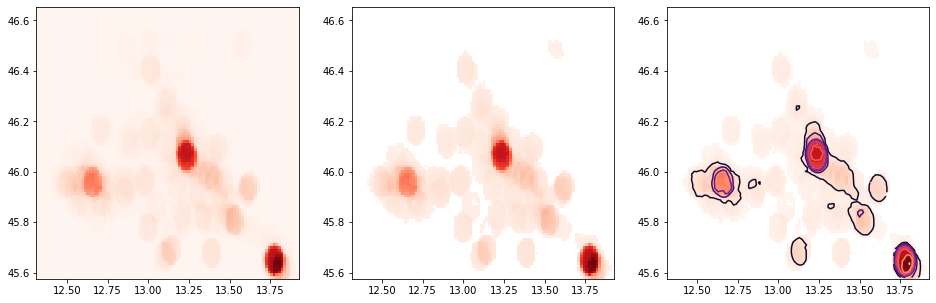

In [14]:

fig, (ax1,ax2, ax3) = plt.subplots(figsize=(16,5), nrows=1, ncols=3)
nn, dG1 = compute_density(dm, X, G, epsilon=0.06)

cmap="Reds"
n_reshape = 100
dG1r = dG1.reshape((n_reshape,n_reshape))

ax1.pcolormesh(xi, yi, dG1r,shading='nearest', cmap=cmap)

threshold=epsilon
dG1rM = np.ma.masked_array(dG1r, dG1r <threshold)
ax2.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, vmin=0)

ax3.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, alpha = 1, zorder = 1)
ax3.contour(xi, yi, dG1rM, cmap="magma", vmin=threshold, zorder = 3)

plt.show()


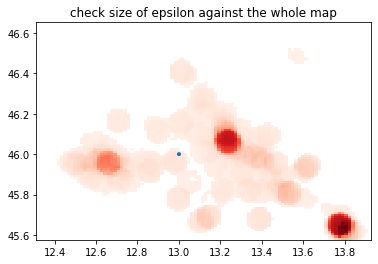

In [15]:
figure, axes = plt.subplots() 
cc = plt.Circle( (13,46), epsilon)
plt.pcolormesh(xi, yi, dG1rM, shading='auto', cmap=cmap, vmin=0)

#axes.set_aspect( 1 ) 
axes.add_artist( cc ) 
plt.title( 'check size of epsilon against the whole map' ) 
plt.show()

In [16]:
def plot_map(df, color_fill = "green", alpha = .2, color_border= "gray" , linewidth = .8):
    for _, row in df.iterrows():
        x, y = list(zip(*row.poly)) 
        plt.fill(x,y, color = color_fill, alpha = alpha, zorder=1)
        plt.plot(x,y, color = color_border, linewidth=linewidth, zorder=2)

In [17]:
#load data from file
ita = pd.read_json(r'./maps/FVG/FVG_mappa.json', orient='records')
# filter a single region
fvg=ita[ ita.istat_r==6]
# plot the map


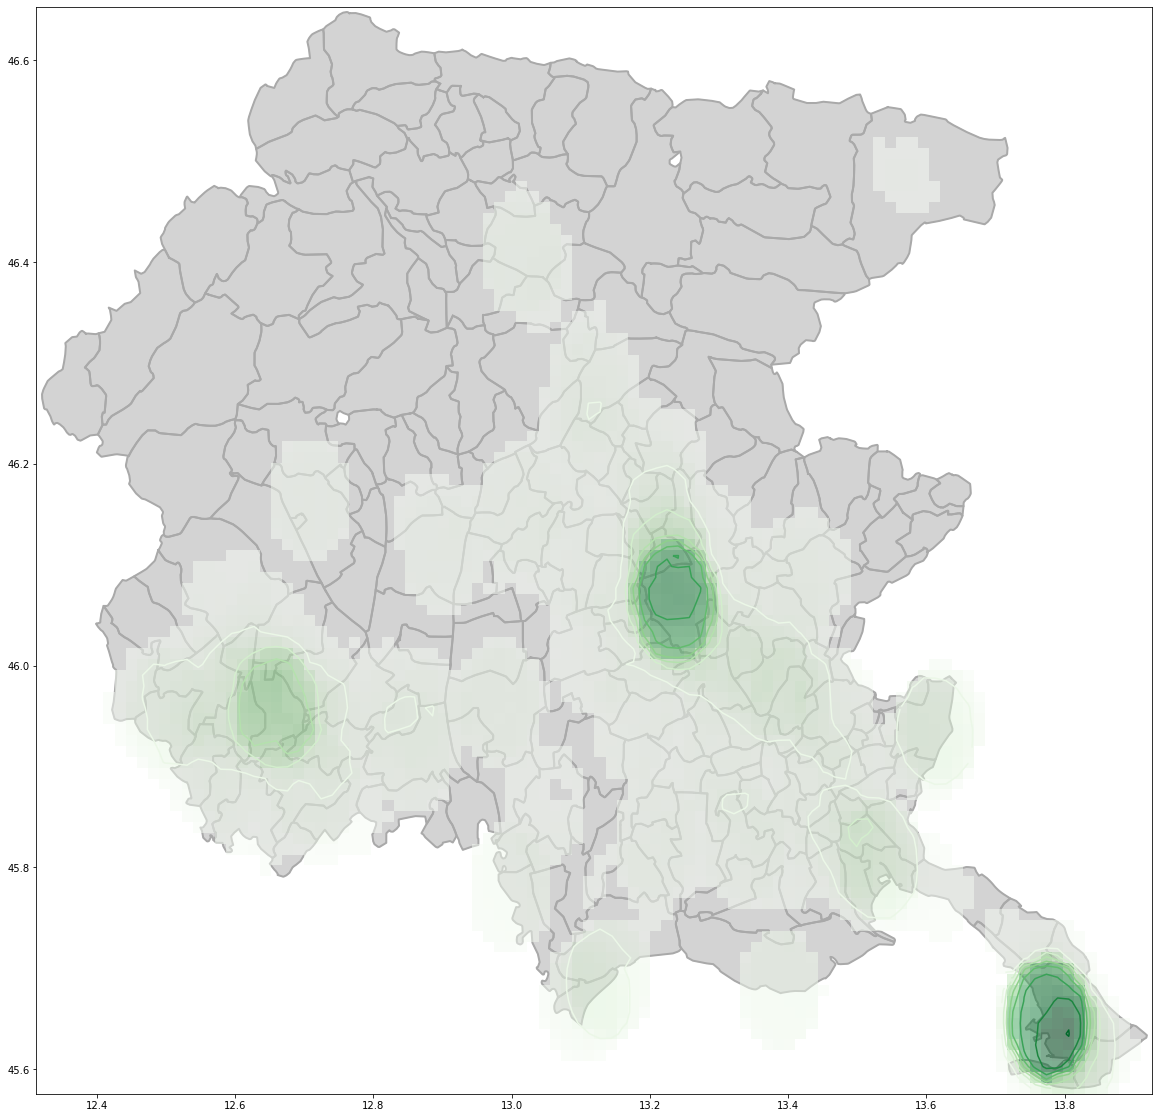

In [18]:
fig, ax = plt.subplots(figsize=(20,20))
plot_map(fvg, color_fill = "lightgray", alpha = 1, color_border= "darkgray" , linewidth = 2)
plt.pcolormesh(xi, yi, dG1rM, shading='auto', cmap="Greens",alpha = .5, zorder = 3)
plt.contour(xi, yi, dG1rM, cmap="Greens", vmin=threshold, zorder = 4)
plt.show()

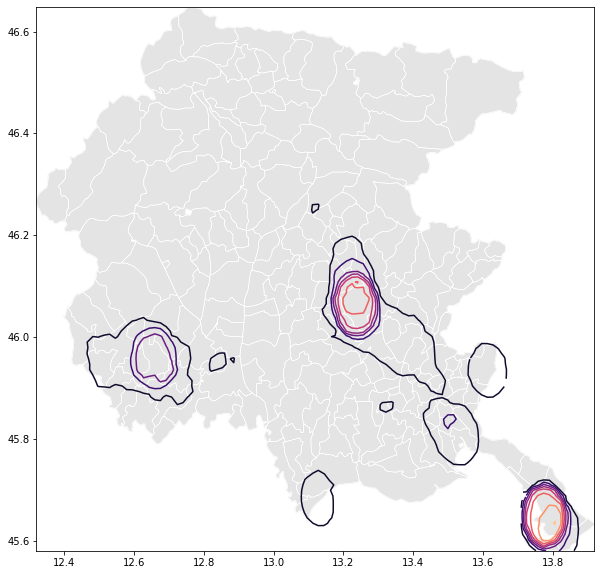

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
plot_map(fvg, color_fill = "lightgray", alpha = .6, color_border= "white" , linewidth = .8)
plt.contour(xi, yi, dG1rM, cmap="magma", vmin=threshold, zorder = 4)

plt.show()

## other data points

In [20]:
dd = pd.read_csv(r'./data/summary.csv')
dd = dd[ dd.x > 12.3]
dd = dd[ dd.x < 14.0]
dd = dd[ dd.y > 45.6]
dd = dd[ dd.y < 46.7]

In [21]:
D = np.array(dd[ ['x','y' ] ]) 

In [22]:
dm = distance_matrix(G,D)
n_data_points= D.shape[0]
n_grid_points= G.shape[0]
n_reshape = np.sqrt(n_grid_points).astype(int)

In [23]:
epsilon=5e-2
nn, dens = compute_density(dm, D, G,  epsilon=epsilon)

In [24]:
dens_r = dens.reshape((n_reshape,n_reshape))


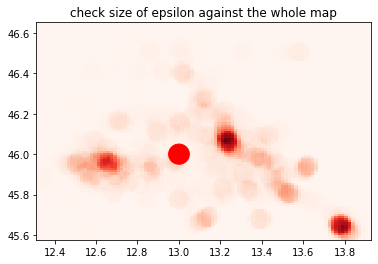

In [25]:
figure, axes = plt.subplots() 
plt.pcolormesh(xi, yi, dens_r, shading='auto', cmap=cmap, vmin=0)
cc = plt.Circle( (13,46), epsilon,color = "red")
axes.add_artist( cc ) 
plt.title( 'check size of epsilon against the whole map' ) 
plt.show()

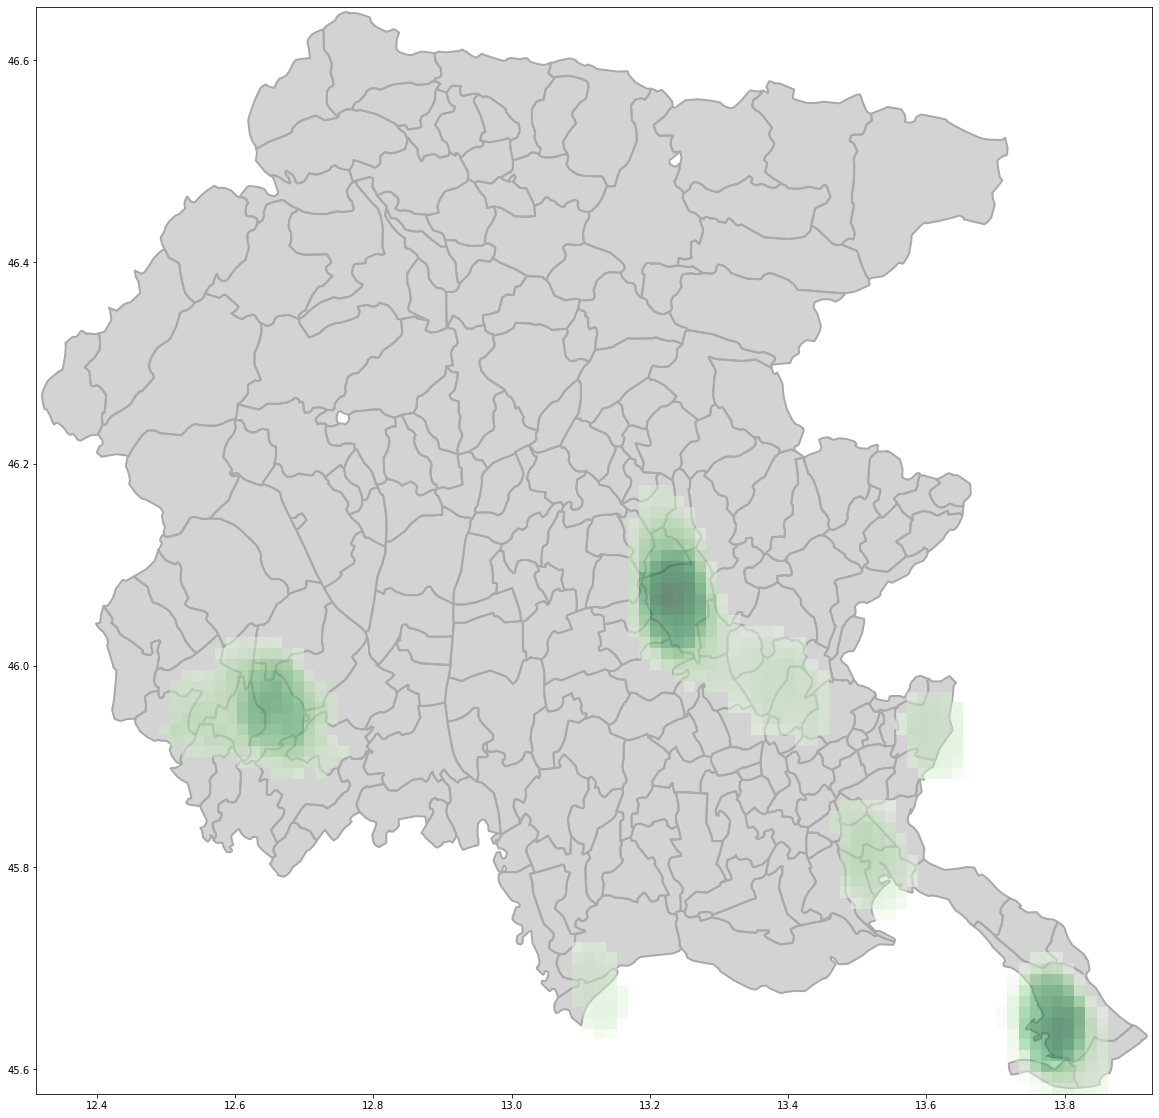

In [26]:
fig, ax = plt.subplots(figsize=(20,20))
cmap = "Greens"
plot_map(fvg, color_fill = "lightgray", alpha = 1, color_border= "darkgray" , linewidth = 2)


threshold=epsilon
dens_r_M = np.ma.masked_array(dens_r, dG1r <threshold)
plt.pcolormesh(xi, yi, dens_r_M, shading='auto', cmap=cmap, alpha = .5, zorder = 4)

#plt.contour(xi, yi, dens_r_M, cmap=cmap,  zorder = 5)


plt.show()

## simple plot (encoding size and color)

C:\Users\morea\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


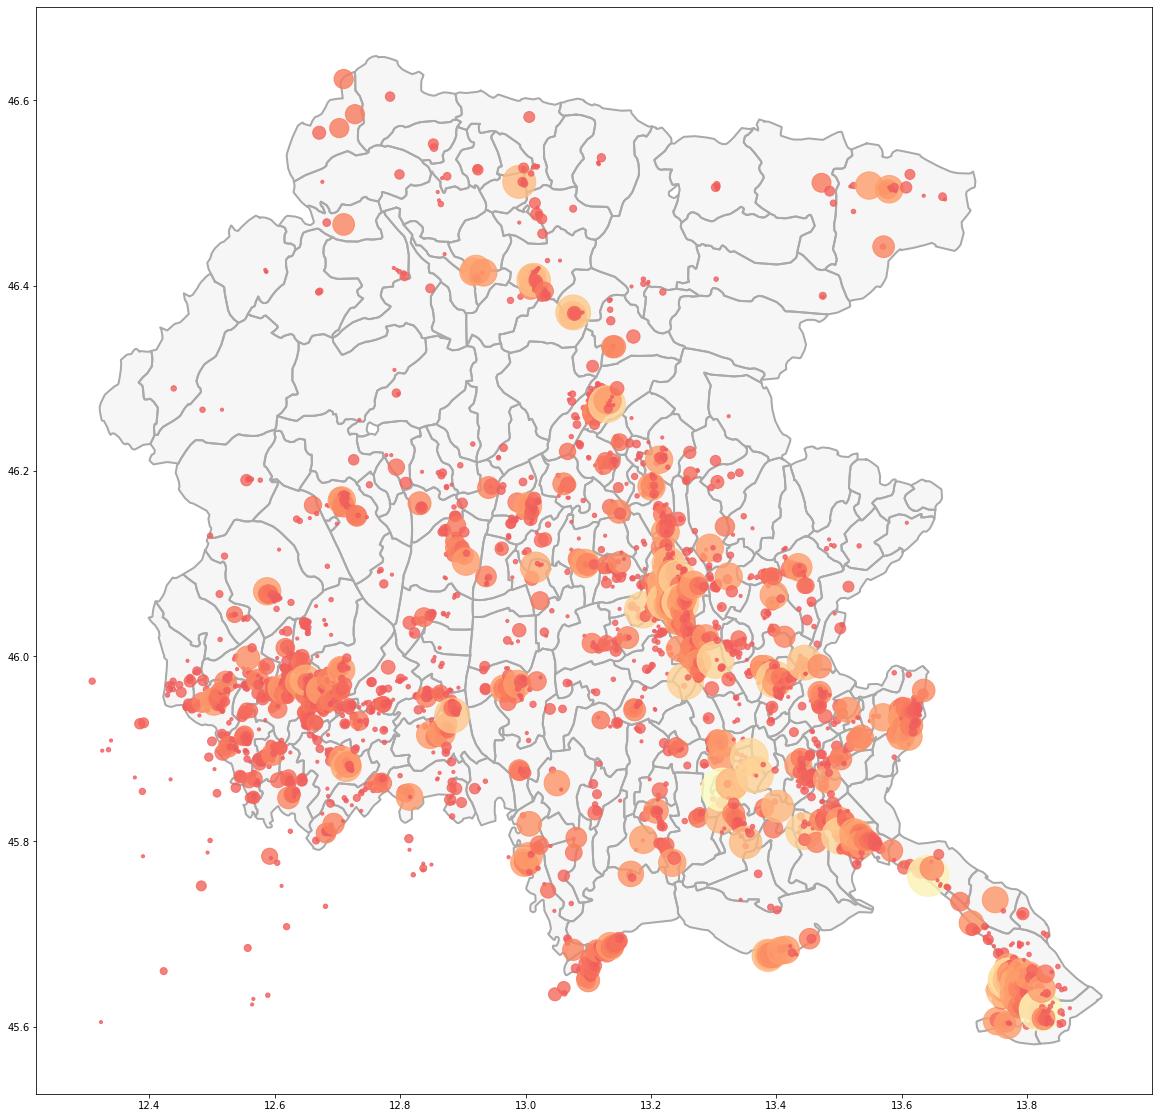

In [27]:
fig, ax = plt.subplots(figsize=(20,20))

plot_map(fvg, color_fill = "lightgray", alpha = .2, color_border= "darkgray" , linewidth = 2)

plt.scatter(dd.x,dd.y, s=dd.z*10, c = dd.z, alpha = .8, cmap = "magma", zorder = 5)


# KMEANS clustering on other attributes

In [28]:
bsd = pd.read_csv('./data/company_data.csv')
bsd.columns

Index(['idCompany', 'totAssets', 'totEquity', 'noi', 'personnel', 'prod',
       'debts', 'deprec', 'valCost', 'totIntang', 'revenues', 'valAdded',
       'yearsInBusiness', 'staffTurnover', 'staffBalance', 'StockAll'],
      dtype='object')

In [29]:
bsd = bsd[ ['totEquity', 'yearsInBusiness',  'StockAll','staffTurnover', 'staffBalance'] ]
bsd = np.array(bsd)
bsd = (bsd - bsd.mean(axis=0))/bsd.std(axis=0)

In [30]:
bsd

array([[-0.25796766,  2.26564459, -0.25910043,  0.22043974,  0.02701255],
       [-0.22647275,  1.96185394, -0.36968969, -0.34710874, -0.11007394],
       [-0.23713339,  2.01251555, -0.16694271,  0.27915165,  0.98661798],
       ...,
       [ 1.00954266, -1.26222953,  1.08640231, -0.05354918,  1.12370447],
       [ 0.54308819,  1.50983779,  0.72698719,  0.2008691 ,  0.43827202],
       [-0.25082918, -1.28890296, -0.32361083, -0.13183173, -0.24716043]])

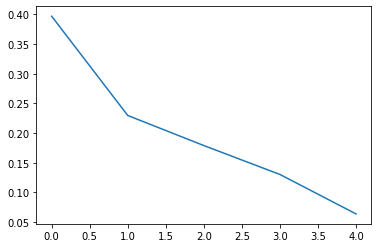

In [31]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(bsd)
plt.plot(pca.explained_variance_ratio_)


In [32]:
cmp = pca.components_
cmp

array([[ 0.57783855,  0.26818664,  0.62494524,  0.43782011,  0.10924984],
       [-0.20033064, -0.38090901, -0.11017829,  0.46371288,  0.76655533],
       [ 0.21425957, -0.86294708,  0.17095397,  0.10446213, -0.41143355],
       [-0.44157613,  0.18685943, -0.09923516,  0.72924872, -0.47795685],
       [ 0.62054299,  0.05822483, -0.74714879,  0.22487302, -0.0523171 ]])

In [33]:
cmp[0]

array([0.57783855, 0.26818664, 0.62494524, 0.43782011, 0.10924984])

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=0).fit(bsd)


In [35]:
bsd.shape

(1558, 5)

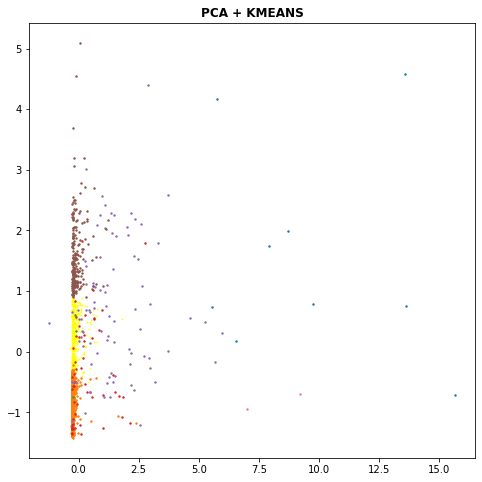

In [36]:
_, ax = plt.subplots(figsize=(8,8))
plot_clusters(bsd[:,:3] , kmeans.labels_ , title = "PCA + KMEANS")
plt.show()



# CLUSTERING

In [37]:
epsilon = 1
minPoints = 10
dm = distance_matrix(X,X)
is_core = np.zeros(n).astype(int)
for j in range(n):
    n_neibs = np.unique(np.where( dm[j] < epsilon )).flatten()
    if len(n_neibs) >= minPoints: is_core[j] = 1


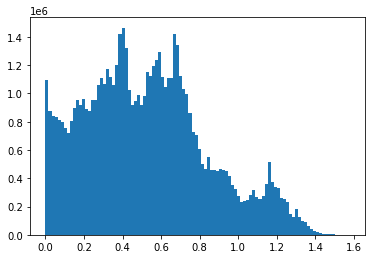

In [38]:
#compute the minimum distances of the k-th nearest neighbour
from scipy.spatial import distance_matrix
dm = distance_matrix(X,X)
values = np.reshape(dm,-1)
plt.hist(values, bins = 100)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

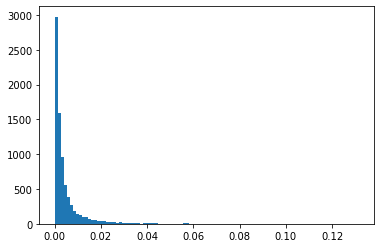

In [39]:
knn = 5
min_distances= np.partition(dm, knn, axis=0)[knn] 
plt.hist(min_distances, bins = 100)
plt.show

In [40]:
for p in range(10,100,10):
    print(f"il {p}° percentile ==> distanza {np.percentile(min_distances, p)}")

il 10° percentile ==> distanza 0.0
il 20° percentile ==> distanza 0.0006330473856284708
il 30° percentile ==> distanza 0.0010034597067725786
il 40° percentile ==> distanza 0.0014646284710803654
il 50° percentile ==> distanza 0.0020877511824960973
il 60° percentile ==> distanza 0.0029113371317389977
il 70° percentile ==> distanza 0.004037953964497539
il 80° percentile ==> distanza 0.006120130593571729
il 90° percentile ==> distanza 0.011513026090894591


In [41]:
# dm = distance_matrix(X,X)
# index = 2
# distances = dm[index]

# epsilon = .02

# distances_epsilon = distances[ distances <= epsilon]



In [42]:
# def epsilon_neighborhood( index, epsilon):
#     distances = dm[index]
#     neighbours_indices = np.where( distances <= epsilon )
#     return np.array(neighbours_indices)[0]

# def is_core(p, epsilon, minPoints):
#     nbhood =  epsilon_neighborhood(p, epsilon)
#     return (len(nbhood) >= minPoints)

# def is_directly_density_reachable(p,q, epsilon, minPoints):
#     '''An object q is directly density-reachable from object p 
#     if q is within the ε-Neighborhood of p 
#     and p is a core object'''
#     is_ddr = False
#     neib=np.array([])
#     if is_core(p, epsilon, minPoints):
#         neib = epsilon_neighborhood(p, epsilon)
#         if (q in neib):
#             is_ddr = True
#     return is_ddr, neib




In [43]:
# for eps in [.11, .002]:
#     nbindexes = epsilon_neighborhood(12, eps)
#     print(nbindexes)
    

In [44]:
# for i in range(70):
#     nbindexes =  epsilon_neighborhood(i, epsilon=.0011)
#     print( len(nbindexes))
    

In [45]:
# epsilon = .0011
# minPoints = 26
# t,f= 0,0
# for p in range(100):
#     for q in range(100):
#         is_ddr, neib = is_directly_density_reachable(p,q, epsilon, minPoints)
#         if is_ddr: 
#             t+=1 
#         else: 
#             f+=1

# print(t,f)

In [46]:
#retrieva all points density reachable from P

# def density_reachable( p, epsilon, minPoints):
#     density_reachable = []
#     for q in list(points):
#         is_ddr, neib = is_directly_density_reachable(p,q, epsilon, minPoints)
#         if is_ddr: 
#             density_reachable.append(neib)
#     return density_reachable



In [47]:

def clustering_DBSCAN_noise(X, epsilon, minPoints):
    n_points = len(X)
    dm = distance_matrix(X,X)
    # identify core points 
    is_core = np.zeros(n_points).astype(int)
    for j in range(n_points):
        n_neibs = np.unique(np.where( dm[j] < epsilon )).flatten()
        if len(n_neibs) >= minPoints: is_core[j] = 1
 
    
    points = np.arange(n_points)
    clusters = np.zeros(n_points)

    cluster_id = 0
    tovisit = np.sum(clusters == 0)
    while(tovisit > 0):
        is_core_unvisited = ((clusters == 0) & (is_core == 1))
        p = np.random.choice(points[ is_core_unvisited ])
        # directly density reachable!
        nbhood = np.unique(np.where( dm[p] <= epsilon )).flatten()
        #check indirect reachability  
        
        old_nb_len = 0
        nb_len = len(nbhood)
        while (nb_len>old_nb_len): 
            for q in nbhood: 

                indirect = np.unique(np.where( dm[q] <= epsilon )).flatten()
                nbhood = np.unique(np.append(nbhood, indirect).flatten())
            # add here a condition to keep searching further levels  
            old_nb_len = nb_len
            nb_len = len(nbhood)
  
             
                
        if (len(nbhood) >= minPoints):# is_core:
            cluster_id += 1
            clusters[p] = int(cluster_id)
            for q in nbhood:
                    clusters[q] = int(cluster_id)
        else: #is halo
            clusters[p] = int(-1)

        is_core_unvisited = ((clusters == 0) & (is_core == 1))
        tovisit = len(points[is_core_unvisited])
    
    #encode "halo" as 0    
    clusters[ clusters == -1] = 0
    return clusters
    

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0}


Text(0, 0.5, 'Y')

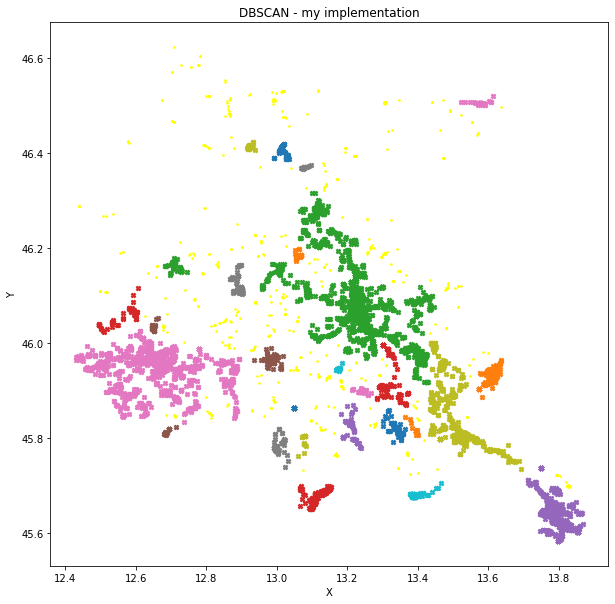

In [48]:
epsilon = .02
minPoints= 20
np.random.seed(123)
clusters = clustering_DBSCAN_noise(X, epsilon=epsilon, minPoints=minPoints)
print((set(clusters)))

data['cluster']=clusters.astype(int)
data = data[ [ 'cf', 'company', 'lat', 'lon', 'cluster'] ]
data.to_csv('./data/FVG_comp_clusters.csv', index=False)

plt.figure(figsize=(10,10))

for clust in list(set(data.cluster)):
    x = np.array(data.lon[ data.cluster == clust ])
    y = np.array(data.lat[ data.cluster == clust ])
    if clust == 0: 
        plt.scatter(x, y, s=10, marker = ".", color = "yellow", label="halo")
    else:
        plt.scatter(x, y, s=20, marker = "X", label=f"Cluster{clust}")

plt.title('DBSCAN - my implementation')
plt.xlabel('X')
plt.ylabel('Y')

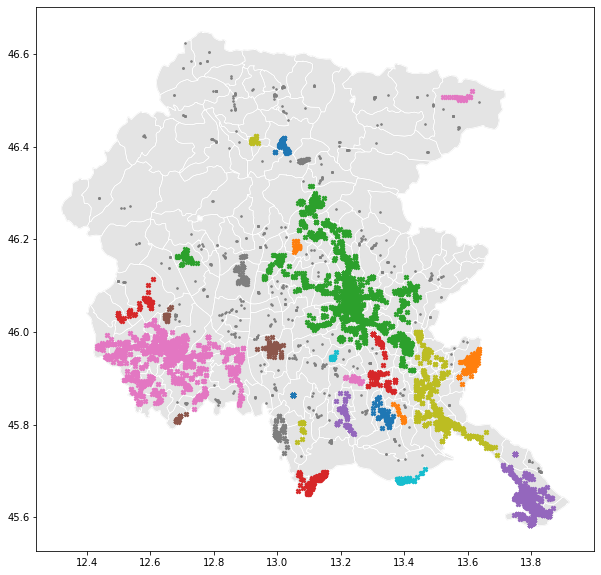

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
plot_map(fvg, color_fill = "lightgray", alpha = .6, color_border= "white" , linewidth = .8)
for clust in list(set(data.cluster)):
    x = np.array(data.lon[ data.cluster == clust ])
    y = np.array(data.lat[ data.cluster == clust ])
    if clust == 0: 
        plt.scatter(x, y, s=10, marker = ".", color = "gray",label="halo", zorder=3)
    else:
        plt.scatter(x, y, s=20, marker = "X",  label=f"Cluster{clust}", zorder=4)


In [50]:

# np.random.seed(999)
# clusters = clustering_DBSCAN_noise(X, epsilon=epsilon, minPoints=minPoints)
# print((set(clusters)))

# data['cluster']=clusters.astype(int)
# data = data[ [ 'cf', 'company', 'lat', 'lon', 'cluster'] ]
# data.to_csv('./data/FVG_comp_clusters.csv', index=False)

# plt.figure(figsize=(10,10))

# for clust in list(set(data.cluster)):
#     x = np.array(data.lon[ data.cluster == clust ])
#     y = np.array(data.lat[ data.cluster == clust ])
#     if clust == 0: 
#         plt.scatter(x, y, s=10, marker = ".", color = "yellow", label="halo")
#     else:
#         plt.scatter(x, y, s=20, marker = "X", label=f"Cluster{clust}")


# #plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
# #plt.legend()
# plt.title('DBSCAN - my implementation')
# plt.xlabel('X')
# plt.ylabel('Y')

1


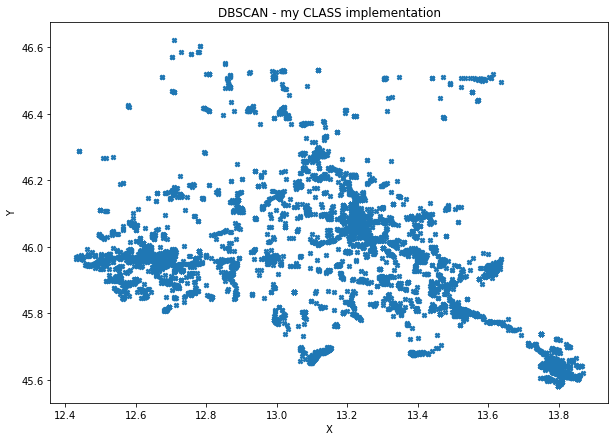

In [51]:
from sklearn.cluster import DBSCAN
epsilon = 2.2
minPoints= 20

clustering = DBSCAN(eps=epsilon, min_samples=minPoints).fit(X)
cc = clustering.labels_
plt.figure(figsize=(10,7))
for clust in list(set(cc)):
    x = np.array(data.lon[ clust == cc ])
    y = np.array(data.lat[ clust == cc ])
    if clust == -1: 
        plt.scatter(x, y, s=10, marker = ".", color = "yellow", label="halo")
    else:
        plt.scatter(x, y, s=20, marker = "X", label=f"Cluster{clust}")


#plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
#plt.legend()
plt.title('DBSCAN - my CLASS implementation')
plt.xlabel('X')
plt.ylabel('Y')

print(len(set(cc)))

In [52]:
print(":-D")

:-D


Silhouette score
eg from here
https://gist.github.com/AlexandreAbraham/5544803?msclkid=57d3c2cfb28b11ec853386a9714df71b


calculate comparison (precision, recall) as in this
https://towardsdatascience.com/evaluating-clustering-results-f13552ee7603


In [54]:
from sklearn.metrics.cluster import fowlkes_mallows_score

np.random.seed(999)
clusters1 = clustering_DBSCAN_noise(X, epsilon=.0015, minPoints=20)
plot_clusters(X, clusters1)

clusters2 = clustering_DBSCAN_noise(X, epsilon=.0010, minPoints=20)
plot_clusters(X, clusters2)

clusters3 = clustering_DBSCAN_noise(X, epsilon=.0005, minPoints=20)
plot_clusters(X, clusters3)

plt.show()
fowlkes_mallows_score(clusters2, clusters1)

0.9023056585394329

https://geodacenter.github.io/workbook/99_density/lab9b.html?msclkid=d7e2bc81b28d11ec92fcd58b49d1b2ba

Laio / Peak Halo
https://people.sissa.it/~laio/Research/Res_clustering.php
file:///C:/Users/morea/Downloads/Clustering_by_fast_search_and_find_of_density_peaks.pdf


https://github.com/markovmodel/PyEMMA/issues/998?msclkid=96f31b4db28d11ec985ce9b15c28caff

Rodriguez, A., & Laio, A. (2014). Clustering by fast search and find of density peaks. Science, 344(6191), 1492-1496. doi:10.1126/science.1242072


https://github.com/thomasp85/densityClust



Density Peaks 

https://github.com/lanbing510/DensityPeakCluster?msclkid=1fd85fbab28f11ec870cbd2dc3baebd7
